<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
  sentences.extend([x.lower() for x in sent_tokenize(sentence)])

# Получить отдельные предложения и поместить их в sentences

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 271057


Посчитаем для каждого слова его встречаемость.

In [ ]:
import string
words = Counter()

for sentence in tqdm(sentences):
  prccessed_text = sentence.lower().translate(
        str.maketrans('', '', string.punctuation))
  sent_tokenized = word_tokenize(sentence)
  if len(sent_tokenized) > word_threshold:
    continue
  for word in sent_tokenized:
    words[word] += 1


# Расчет встречаемости слов

  0%|          | 0/271057 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 20000
for char, cnt in words.most_common(vocab_size):
  vocab.add(char)

# Наполнение словаря

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 20004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        prccessed_text = sentence.lower().translate(
        str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])
            ]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
len(train_dataset[0])

17

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
model = LanguageModel(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader=train_dataloader):
    num_epoch = 3
    losses = []
    perplexities = []
    print("Perplexities:")
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, train_dataloader))
        print(perplexities[len(perplexities)-1])

        # пусть еще и графики рисует

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(np.arange(len(losses)), losses)
    ax1.set_title('Losses')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")

    ax2.plot(np.arange(len(perplexities)), perplexities)
    ax2.set_title('Perplexity')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Perplexity")

    plt.tight_layout()  # Чтобы графики не перекрывались
    plt.show()

    return losses, perplexities

Training epoch 0::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/6777 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/6777 [00:00<?, ?it/s]

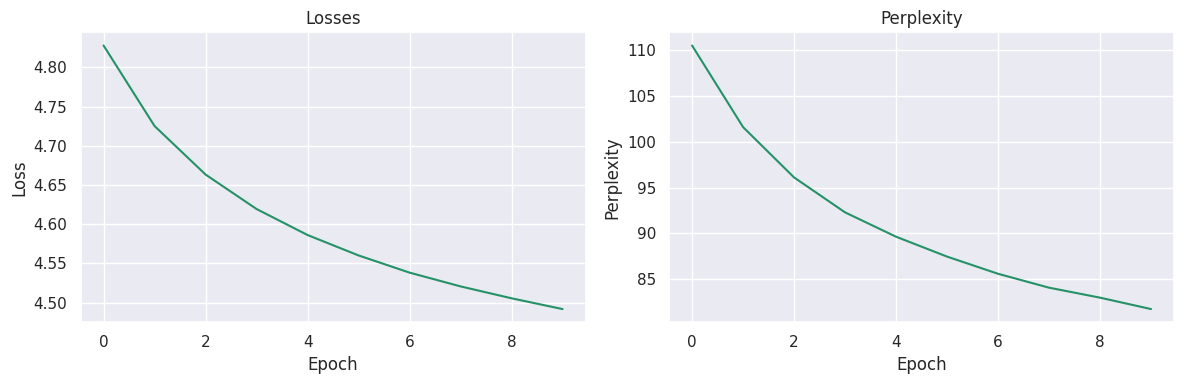

([4.827784545516236,
  4.7251042370530945,
  4.663296867546227,
  4.619327782282914,
  4.5861726320825955,
  4.56015619655371,
  4.5382422724708755,
  4.5206841489145395,
  4.505518890964575,
  4.491781065980119],
 [110.53922606816207,
  101.6143591876436,
  96.10781911011553,
  92.2837089908955,
  89.62157252011828,
  87.44624096252792,
  85.56590405526512,
  84.04610522426263,
  82.95400374537638,
  81.70623924409603])

In [ ]:
# пришлось сильно уменьшить batch_size, размер словаря и hidden_dim, чтобы хватало памяти, повлияет на точность

train_model(model, criterion, optimizer)

In [ ]:
# итоговая перплексия =  81.70623924409603
# можно было бы обучать еще несколько эпох, но оно и так еле-еле обучилось


In [ ]:
#попробуем что-то предсказать
def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    device = 'cpu'
    model = model.to(device)
    words = word_tokenize(starting_seq)

    # Преобразование слов в индексы
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in words
    ]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    generated_words = [ind2word[idx.item()] for idx in input_ids]

    generated_words = [word for word in generated_words if word not in ['<bos>', '<eos>']]

    return ' '.join(generated_words)

In [ ]:
generate_sequence(model, starting_seq='film is good but ')

"film is good but it 's a good movie ."

In [ ]:
# в целом смысл имеет, но модель стоило бы дообучить

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
# попробуем использовать lstm
class LanguageModel_lstm(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # [batch_size, seq_len] -> [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)

        # [batch_size, seq_len, hidden_dim] -> [batch_size, seq_len, hidden_dim]
        output, (hidden_state, cell_state) = self.lstm(embeddings)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]

        # [batch_size, seq_len, hidden_dim] -> [batch_size, seq_len, vocab_size]
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
model_lstm = LanguageModel_lstm(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_lstm.parameters())

In [ ]:

train_model(model_lstm, criterion, optimizer)

Perplexities:


Training epoch 0::   0%|          | 0/6777 [00:00<?, ?it/s]

127.57186127271873


Training epoch 1::   0%|          | 0/6777 [00:00<?, ?it/s]

106.70569876335496


Training epoch 2::   0%|          | 0/6777 [00:00<?, ?it/s]

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.